### Imports + Random seed + loading data

In [47]:
import pandas as pd
import numpy as np
import plotly.express as px
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix


from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

import joblib
import random, os

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

pd.set_option('display.max_columns', 150)


In [48]:
train_df = pd.read_csv("../data/train.csv")
train_df.head()

,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,max_torque,max_power,engine_type,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,rear_brakes_type,displacement,cylinder,transmission_type,gear_box,steering_type,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
0,ID00001,0.515874,0.05,0.644231,C1,4990,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
1,ID00002,0.672619,0.02,0.375000,C2,27003,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
2,ID00003,0.841110,0.02,0.384615,C3,4076,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
3,ID00004,0.900277,0.11,0.432692,C4,21622,1,C1,M2,Petrol,113Nm@4400rpm,88.50bhp@6000rpm,1.2 L K12N Dualjet,2,Yes,Yes,No,Yes,Yes,Drum,1197,4,Automatic,5,Electric,4.8,3995,1735,1515,1335,Yes,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0
4,ID00005,0.596403,0.11,0.634615,C5,34738,2,A,M3,Petrol,91Nm@4250rpm,67.06bhp@5500rpm,1.0 SCe,2,No,No,No,No,Yes,Drum,999,3,Automatic,5,Electric,5.0,3731,1579,1490,1155,No,No,No,No,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0


In [49]:
train_df['is_claim'].value_counts()

is_claim
0    54844
1     3748
Name: count, dtype: int64

### Next cell info
- Printing shape, dtype
- displaying table
- checking null
- visualization for is_claim

In [50]:
print("Shape of train data: ", train_df.shape)
print("\nColumn types summary: \n",train_df.dtypes.value_counts())
print("\nFirst 5 rows:")
display(train_df.head())
print("\nNull values sum : ",train_df.isnull().sum().sum())

target_counts = train_df['is_claim'].value_counts(normalize=True) *100
fig = px.bar(
    x=target_counts.index.astype(str),
    y=target_counts.values,
    title="Target Distribution: is_claim",
    labels={"x": "is_claim", "y": "Percentage"},
    text=[f"{v:.2f}%" for v in target_counts.values]
)
fig.update_layout(width=800, height=600)
fig.update_traces(textposition='outside')
fig.show()

Shape of train data:  (58592, 44)

Column types summary: 
 object     28
int64      12
float64     4
Name: count, dtype: int64

First 5 rows:


,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,max_torque,max_power,engine_type,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,rear_brakes_type,displacement,cylinder,transmission_type,gear_box,steering_type,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
0,ID00001,0.515874,0.05,0.644231,C1,4990,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
1,ID00002,0.672619,0.02,0.375000,C2,27003,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
2,ID00003,0.841110,0.02,0.384615,C3,4076,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
3,ID00004,0.900277,0.11,0.432692,C4,21622,1,C1,M2,Petrol,113Nm@4400rpm,88.50bhp@6000rpm,1.2 L K12N Dualjet,2,Yes,Yes,No,Yes,Yes,Drum,1197,4,Automatic,5,Electric,4.8,3995,1735,1515,1335,Yes,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0
4,ID00005,0.596403,0.11,0.634615,C5,34738,2,A,M3,Petrol,91Nm@4250rpm,67.06bhp@5500rpm,1.0 SCe,2,No,No,No,No,Yes,Drum,999,3,Automatic,5,Electric,5.0,3731,1579,1490,1155,No,No,No,No,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0



Null values sum :  0


#### Now, Dropping the 'policy_id' column 

In [51]:
train_df.drop(columns=['policy_id'], inplace=True)

train_df.head()

,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,max_torque,max_power,engine_type,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,rear_brakes_type,displacement,cylinder,transmission_type,gear_box,steering_type,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
0,0.515874,0.05,0.644231,C1,4990,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
1,0.672619,0.02,0.375000,C2,27003,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
2,0.841110,0.02,0.384615,C3,4076,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
3,0.900277,0.11,0.432692,C4,21622,1,C1,M2,Petrol,113Nm@4400rpm,88.50bhp@6000rpm,1.2 L K12N Dualjet,2,Yes,Yes,No,Yes,Yes,Drum,1197,4,Automatic,5,Electric,4.8,3995,1735,1515,1335,Yes,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0
4,0.596403,0.11,0.634615,C5,34738,2,A,M3,Petrol,91Nm@4250rpm,67.06bhp@5500rpm,1.0 SCe,2,No,No,No,No,Yes,Drum,999,3,Automatic,5,Electric,5.0,3731,1579,1490,1155,No,No,No,No,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0


### Now,
- Separating feature types into numeric and categorical
- Displaying the categorical columns
- Displaying boolean (yes/no) columns
- Unique counts in categorical columns
- Displaying the max_power, max_torque to know what to change in the values

In [52]:
numeric_cols = train_df.select_dtypes(include=["int64", "float64"]).columns
categorical_cols = train_df.select_dtypes(include=["object"]).columns.tolist()
print("\nNumeric Columns Count:", len(numeric_cols))
print("Categorical Columns Count:", len(categorical_cols))
print("\nCategorical Columns:\n", categorical_cols)

yes_no_cols = [col for col in categorical_cols if train_df[col].isin(["Yes", "No"]).all()]
print("\nYes/No Boolean Columns:\n", yes_no_cols)

cat_unique_counts = {col: train_df[col].nunique() for col in categorical_cols}
cat_unique_counts = dict(sorted(cat_unique_counts.items(), key=lambda x: x[1], reverse=True))
print("\nUnique category counts per categorical column:\n", cat_unique_counts)

print("\nSample values for 'max_power' and 'max_torque':")
print("max_power →", train_df['max_power'].head(3).tolist())
print("max_torque →", train_df['max_torque'].head(3).tolist())


Numeric Columns Count: 16
Categorical Columns Count: 27

Categorical Columns:
 ['area_cluster', 'segment', 'model', 'fuel_type', 'max_torque', 'max_power', 'engine_type', 'is_esc', 'is_adjustable_steering', 'is_tpms', 'is_parking_sensors', 'is_parking_camera', 'rear_brakes_type', 'transmission_type', 'steering_type', 'is_front_fog_lights', 'is_rear_window_wiper', 'is_rear_window_washer', 'is_rear_window_defogger', 'is_brake_assist', 'is_power_door_locks', 'is_central_locking', 'is_power_steering', 'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror', 'is_ecw', 'is_speed_alert']

Yes/No Boolean Columns:
 ['is_esc', 'is_adjustable_steering', 'is_tpms', 'is_parking_sensors', 'is_parking_camera', 'is_front_fog_lights', 'is_rear_window_wiper', 'is_rear_window_washer', 'is_rear_window_defogger', 'is_brake_assist', 'is_power_door_locks', 'is_central_locking', 'is_power_steering', 'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror', 'is_ecw', 'is_speed_alert']



### Now,
- Created a function to clean max_power and max_torque features and applied it.
- Mapping yes_no_columns to 1 & 0 values

In [53]:
def extract_numeric(value):
    try:
        return float(re.findall(r'\d+\.?\d*', str(value))[0])
    except:
        return np.nan

train_df['max_power'] = train_df['max_power'].apply(extract_numeric)
train_df['max_torque'] = train_df['max_torque'].apply(extract_numeric)

train_df[yes_no_cols] = train_df[yes_no_cols].replace({'Yes':1,'No':0})

display(train_df.head(3))
print("Null Values: ", train_df.isnull().sum().sum())

C:\Users\arkha\AppData\Local\Temp\ipykernel_2096\4157275436.py:10: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,max_torque,max_power,engine_type,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,rear_brakes_type,displacement,cylinder,transmission_type,gear_box,steering_type,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
0,0.515874,0.05,0.644231,C1,4990,1,A,M1,CNG,60.0,40.36,F8D Petrol Engine,2,0,0,0,1,0,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,0,0,0,0,0,0,0,1,0,0,0,1,0,0
1,0.672619,0.02,0.375000,C2,27003,1,A,M1,CNG,60.0,40.36,F8D Petrol Engine,2,0,0,0,1,0,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2,0.841110,0.02,0.384615,C3,4076,1,A,M1,CNG,60.0,40.36,F8D Petrol Engine,2,0,0,0,1,0,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,0,0,0,0,0,0,0,1,0,0,0,1,0,0


Null Values:  0


### Now,

- Printing the cardinality of categorcal features

In [54]:
categorical_cols = train_df.select_dtypes(include=["object"]).columns.tolist()

cat_unique_counts = {col: train_df[col].nunique() for col in categorical_cols}
cat_unique_counts = dict(sorted(cat_unique_counts.items(), key=lambda x: x[1], reverse=True))
print("\nUnique category counts per categorical column:\n", cat_unique_counts)


Unique category counts per categorical column:
 {'area_cluster': 22, 'model': 11, 'engine_type': 11, 'segment': 6, 'fuel_type': 3, 'steering_type': 3, 'rear_brakes_type': 2, 'transmission_type': 2}


### Now,

- Defining features groups based on the cardinality (value counts)
- Printing the groups

In [55]:
target_col = 'is_claim'
numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()

# Remove target column
if target_col in numeric_cols:
    numeric_cols.remove(target_col)

#Defining groups
low_cardinality = [col for col, count in cat_unique_counts.items() if count <=10]
high_cardinality = [col for col, count in cat_unique_counts.items() if count>10]


print("Numeric columns:", len(numeric_cols))
print("Low-cardinality categorical columns:", low_cardinality)
print("High-cardinality categorical columns:", high_cardinality)
print("Groups defined successfully for preprocessing.")

train_df.head(3)

Numeric columns: 34
Low-cardinality categorical columns: ['segment', 'fuel_type', 'steering_type', 'rear_brakes_type', 'transmission_type']
High-cardinality categorical columns: ['area_cluster', 'model', 'engine_type']
Groups defined successfully for preprocessing.


,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,max_torque,max_power,engine_type,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,rear_brakes_type,displacement,cylinder,transmission_type,gear_box,steering_type,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
0,0.515874,0.05,0.644231,C1,4990,1,A,M1,CNG,60.0,40.36,F8D Petrol Engine,2,0,0,0,1,0,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,0,0,0,0,0,0,0,1,0,0,0,1,0,0
1,0.672619,0.02,0.375000,C2,27003,1,A,M1,CNG,60.0,40.36,F8D Petrol Engine,2,0,0,0,1,0,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2,0.841110,0.02,0.384615,C3,4076,1,A,M1,CNG,60.0,40.36,F8D Petrol Engine,2,0,0,0,1,0,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,0,0,0,0,0,0,0,1,0,0,0,1,0,0


### Now,
#### Applying encoding based on category type
##### Frequency(saving the freq_encoding_map.pkl) & One-hot



In [56]:
# Frequency encoding for high-cardinality columns
freq_encoding_map = {}

for col in high_cardinality:
    freq_map = train_df[col].value_counts(normalize=True).to_dict()
    freq_encoding_map[col] = freq_map
    train_df[col] = train_df[col].map(freq_map)

joblib.dump(freq_encoding_map, "../models/freq_encoding_maps.pkl")

# One-hot encoding for low-cardinality columns
train_df = pd.get_dummies(train_df, columns=low_cardinality, drop_first=True, dtype=int)

print("Encoding complete.")
print("New shape after encoding:", train_df.shape)
print("All object columns left (should be none):", train_df.select_dtypes('object').columns.tolist())
display(train_df.head(3))


Encoding complete.
New shape after encoding: (58592, 49)
All object columns left (should be none): []


,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,model,max_torque,max_power,engine_type,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,displacement,cylinder,gear_box,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim,segment_B1,segment_B2,segment_C1,segment_C2,segment_Utility,fuel_type_Diesel,fuel_type_Petrol,steering_type_Manual,steering_type_Power,rear_brakes_type_Drum,transmission_type_Manual
0,0.515874,0.05,0.644231,0.025055,4990,1,0.25512,60.0,40.36,0.25512,2,0,0,0,1,0,796,3,5,4.6,3445,1515,1475,1185,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1
1,0.672619,0.02,0.375000,0.125307,27003,1,0.25512,60.0,40.36,0.25512,2,0,0,0,1,0,796,3,5,4.6,3445,1515,1475,1185,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1
2,0.841110,0.02,0.384615,0.104127,4076,1,0.25512,60.0,40.36,0.25512,2,0,0,0,1,0,796,3,5,4.6,3445,1515,1475,1185,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1


### Now,
#### Feature Engineering
- power_to_weight: This ratio is a classic indicator of vehicle performance & speed potential.  
i. A car with high power but low weight accelerates faster - usually driven more aggressively - higher accident/claim risk.  
ii. Heavy cars with lower power are safer/stable - lower risk.

- torque_to_weight:  
i. Higher ratio = quicker acceleration, often riskier driving.  
ii. Lower ratio = less responsive, safer driving.

- car_volume: This gives an approximate vehicle size.  
i. Large cars (SUVs, sedans) might have better crash protection  
ii. Smaller cars (hatchbacks) might be lighter, cheaper - more likely to be insured with minimal.  coverage and possibly more claims.  
iii. converted to mm³ to m³

- age_gap:  
i. Older owners + newer cars → careful drivers (lower risk).  
ii. Younger owners + old cars → more risk-taking, higher chance of claims.

- engine_efficiency:  
i. Efficiency indicator: lower ratio = efficient engine (possibly newer tech cars, lower claims)   
ii. Newer engines produce more power per cc - tech difference  

- cylinder_to_power:  
i. Cars with higher power but fewer cylinders tend to be lightweight - potentially driven more aggressively - therefore, higher claim probability.  
ii. Cars with many cylinders but moderate power are heavier, more stable (SUVs, sedans) - lower accident risk.

- tenure_to_car_age:  
i. Indicates if the owner took the policy early in car’s life or later.

- tenure_to_owner_age:  
i.Suggests how long the person’s been insured relative to their age.

In [57]:
#alt 0179 - ³

In [58]:
#1 performance indicator (risk of aggressive driving)
train_df['power_to_weight'] = train_df['max_power']/train_df['gross_weight']

#2 acceleration indicator
train_df['torque_to_weight'] = train_df['max_torque']/train_df['gross_weight']

#3 car volume - physical vehicle size - mm³ to m³
train_df['car_volume'] = (train_df['length']*train_df['width']*train_df['height'])/1e9

#4 difference btwn owner age and car age
train_df['age_gap'] = train_df['age_of_policyholder'] - train_df['age_of_car']

#5 displacement per unit power
train_df['engine_efficiency'] = train_df['displacement']/train_df['max_power']

#6 engine build strength  vs output
train_df['cylinder_to_power'] = train_df['cylinder']/train_df['max_power']

#7 density factor
train_df['density_factor'] = train_df['population_density'] * train_df['area_cluster']

#8 tenure to car age
train_df['tenure_to_car_age'] = train_df['policy_tenure']/train_df['age_of_car']

#9 tenure to policy holder age
train_df['tenure_to_owner_age'] = train_df['policy_tenure']/train_df['age_of_policyholder']

train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.fillna(0, inplace=True)
print("Any null values?: ",train_df.isnull().sum().sum())

print("Feature engineering is complete")
print("New shape after adding engineered features:", train_df.shape)
display(train_df.head(3))

Any null values?:  0
Feature engineering is complete
New shape after adding engineered features: (58592, 58)


,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,model,max_torque,max_power,engine_type,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,displacement,cylinder,gear_box,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim,segment_B1,segment_B2,segment_C1,segment_C2,segment_Utility,fuel_type_Diesel,fuel_type_Petrol,steering_type_Manual,steering_type_Power,rear_brakes_type_Drum,transmission_type_Manual,power_to_weight,torque_to_weight,car_volume,age_gap,engine_efficiency,cylinder_to_power,density_factor,tenure_to_car_age,tenure_to_owner_age
0,0.515874,0.05,0.644231,0.025055,4990,1,0.25512,60.0,40.36,0.25512,2,0,0,0,1,0,796,3,5,4.6,3445,1515,1475,1185,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0.034059,0.050633,7.698283,0.594231,19.722498,0.074331,125.022529,10.317472,0.800759
1,0.672619,0.02,0.375000,0.125307,27003,1,0.25512,60.0,40.36,0.25512,2,0,0,0,1,0,796,3,5,4.6,3445,1515,1475,1185,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0.034059,0.050633,7.698283,0.355000,19.722498,0.074331,3383.670569,33.630926,1.793649
2,0.841110,0.02,0.384615,0.104127,4076,1,0.25512,60.0,40.36,0.25512,2,0,0,0,1,0,796,3,5,4.6,3445,1515,1475,1185,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0.034059,0.050633,7.698283,0.364615,19.722498,0.074331,424.421013,42.055513,2.186887


### Now,
#### Visualizing the Heatmap of correlation of all numeric columns with the target

In [59]:
# computing correlation of all numeric columns with the target
corr_with_target = (
    train_df.corr(numeric_only=True)['is_claim']
    .sort_values(ascending=False)
    .to_frame(name='Correlation_with_is_claim')
)

#createing the heatmap
fig = px.imshow(
    corr_with_target,
    color_continuous_scale="Rainbow",
    title="Correlation of Numeric Features with Target (is_claim)",
    text_auto='.4f',
    aspect="auto"
)

fig.update_layout(
    width=600,           # narrow, since it’s one-column wide
    height=900,          # tall enough for all features
    xaxis_title="Target: is_claim",
    yaxis_title="Features",
    coloraxis_colorbar=dict(title="Correlation")
)

fig.show()


### Now,

- splitted in x and y
- selected only non binary columns to scale
- saved the scaler.pkl

In [60]:
x = train_df.drop(columns=['is_claim'])
y = train_df['is_claim']

#selecting binary column names for to not scale them - the variables which contain only 0,1 values
binary_columns = x.isin([0,1]).all()    

#excluding those columns now
columns_to_scale = [col for col in x.columns if not binary_columns[col]]

scaler = StandardScaler()
x[columns_to_scale] = scaler.fit_transform(x[columns_to_scale])

#saving the scaler obj
joblib.dump(scaler, "../models/scaler.pkl")

print("Scaled only non-binary numeric columns")
print(f"Scaled columns count: {len(columns_to_scale)}")

display(x.head(3))

Scaled only non-binary numeric columns
Scaled columns count: 29


,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,model,max_torque,max_power,engine_type,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,displacement,cylinder,gear_box,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,segment_B1,segment_B2,segment_C1,segment_C2,segment_Utility,fuel_type_Diesel,fuel_type_Petrol,steering_type_Manual,steering_type_Power,rear_brakes_type_Drum,transmission_type_Manual,power_to_weight,torque_to_weight,car_volume,age_gap,engine_efficiency,cylinder_to_power,density_factor,tenure_to_car_age,tenure_to_owner_age
0,-0.230283,-0.342447,1.422557,-1.136004,-0.783513,-0.671712,0.733764,-1.017838,-1.394156,0.733764,-0.620458,0,0,0,1,0,-1.375713,-1.296417,-0.570334,-1.108893,-1.301882,-1.402768,-0.983846,-0.942828,0,0,0,0,0,0,0,1,0,0,0,1,-1.266548,0,0,0,0,0,0,0,0,1,1,1,-1.398327,-1.048836,-1.366629,1.416158,1.44661,1.56457,-1.137037,-0.223127,-0.567831
1,0.148188,-0.871359,-0.768362,0.180272,0.462975,-0.671712,0.733764,-1.017838,-1.394156,0.733764,-0.620458,0,0,0,1,0,-1.375713,-1.296417,-0.570334,-1.108893,-1.301882,-1.402768,-0.983846,-0.942828,0,0,0,0,0,0,0,1,0,0,0,1,-1.266548,0,0,0,0,0,0,0,0,1,1,1,-1.398327,-1.048836,-1.366629,-0.328068,1.44661,1.56457,1.077178,0.871923,0.443510
2,0.555022,-0.871359,-0.690115,-0.097817,-0.835268,-0.671712,0.733764,-1.017838,-1.394156,0.733764,-0.620458,0,0,0,1,0,-1.375713,-1.296417,-0.570334,-1.108893,-1.301882,-1.402768,-0.983846,-0.942828,0,0,0,0,0,0,0,1,0,0,0,1,-1.266548,0,0,0,0,0,0,0,0,1,1,1,-1.398327,-1.048836,-1.366629,-0.257962,1.44661,1.56457,-0.933599,1.267632,0.844055


### Now,

- splitted further (train,val,test)

In [61]:
x_train, x_temp, y_train, y_temp = train_test_split(
    x, y, test_size=0.3, stratify=y, random_state=SEED
)

x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=SEED
)

print('Stratified splits complete')
print(f"Train shape: {x_train.shape}, Validation shape: {x_val.shape}, Test Shape: {x_test.shape}")
print("\nClass distb (% of claims):")
print(f"Train: {y_train.mean()*100:.2f}% | Val: {y_val.mean()*100:.2f}% | Test: {y_test.mean()*100:.2f}%")

Stratified splits complete
Train shape: (41014, 57), Validation shape: (8789, 57), Test Shape: (8789, 57)

Class distb (% of claims):
Train: 6.40% | Val: 6.39% | Test: 6.39%


### Now,

- Handle class imbalance using SMOTE (only on training data)

In [62]:
from imblearn.over_sampling import SMOTE

print("Before SMOTE:")
print(y_train.value_counts(normalize=True) * 100)

#Applying SMOTE
smote = SMOTE(random_state=SEED)
x_train_res, y_train_res = smote.fit_resample(x_train, y_train)

print("\nAfter SMOTE:")
print(y_train_res.value_counts(normalize=True) * 100)

print("\nApplied SMOTE successfully on training data only.")
print(f"New training shape: {x_train_res.shape}")


Before SMOTE:
is_claim
0    93.602185
1     6.397815
Name: proportion, dtype: float64

After SMOTE:
is_claim
0    50.0
1    50.0
Name: proportion, dtype: float64

Applied SMOTE successfully on training data only.
New training shape: (76780, 57)


### Now,

- Training the baseline models
    - Logistic Regression
    - Decision Tree

In [63]:
# Logistic Regression
log_reg = LogisticRegression( random_state=SEED)

# Decision Tree
dt = DecisionTreeClassifier( random_state=SEED)

# Evaluation Function
def train_evaluate_model(model_name, model):
    model.fit(x_train_res, y_train_res)
    y_val_pred = model.predict(x_val)
    y_val_prob = model.predict_proba(x_val)[:,1]

    print(f"\n{model_name} Evaluation on Validation Set:")
    print(f"Accuracy  : {accuracy_score(y_val, y_val_pred):.4f}")
    print(f"Precision : {precision_score(y_val, y_val_pred):.4f}")
    print(f"Recall    : {recall_score(y_val, y_val_pred):.4f}")
    print(f"F1-Score  : {f1_score(y_val, y_val_pred):.4f}")
    print(f"ROC-AUC   : {roc_auc_score(y_val, y_val_prob):.4f}")

    cm = confusion_matrix(y_val, y_val_pred)
    labels = ["No Claim", "Claim"]

    fig = px.imshow(
        cm,
        text_auto=True,        color_continuous_scale="Blues",
        x=labels,
        y=labels,
        title=f"Confusion Matrix - {model_name} (Validation Set)",
        labels=dict(x="Predicted", y="Actual")
    )
    fig.update_layout(xaxis_side="bottom")
    fig.show()

# Training and evaluating the model & displaying the results
train_evaluate_model("Logistic Regression",log_reg)
train_evaluate_model("Decision Tree", dt)



Logistic Regression Evaluation on Validation Set:
Accuracy  : 0.5945
Precision : 0.0870
Recall    : 0.5623
F1-Score  : 0.1506
ROC-AUC   : 0.5976



Decision Tree Evaluation on Validation Set:
Accuracy  : 0.8490
Precision : 0.0764
Recall    : 0.1228
F1-Score  : 0.0942
ROC-AUC   : 0.5107


### Now,

- Training the Advanced models
    - Random Forest
    - XGBoost
    - LightGBM

In [64]:

# Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    # class_weight='balanced',
    random_state=SEED,
    n_jobs=-1
)


# XGBoost
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=SEED,
    # scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
    n_jobs=-1,
    eval_metric='logloss'
)


# LightGBM
lgb = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=SEED,
    # class_weight='balanced',
    n_jobs=-1,
    verbose = -1
)


#Displaying results
train_evaluate_model("Random Forest",rf)
train_evaluate_model("XGBoost",xgb)
train_evaluate_model("LightGBM",lgb)



Random Forest Evaluation on Validation Set:
Accuracy  : 0.8770
Precision : 0.0887
Recall    : 0.0996
F1-Score  : 0.0939
ROC-AUC   : 0.5917



XGBoost Evaluation on Validation Set:
Accuracy  : 0.8992
Precision : 0.1553
Recall    : 0.1299
F1-Score  : 0.1415
ROC-AUC   : 0.6341



LightGBM Evaluation on Validation Set:
Accuracy  : 0.9067
Precision : 0.1658
Recall    : 0.1139
F1-Score  : 0.1350
ROC-AUC   : 0.6284


### Now,

- Retrieving the Important Features with the help of best model
- Visualizing the top 10 imp features

In [65]:
#feature importances

importances = xgb.feature_importances_
feature_names = x_train_res.columns

#creating a dataframe for viz
feature_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance':importances
}).sort_values(by='Importance', ascending=False).head(10)

top_10_features = feature_imp_df['Feature'].tolist()
pd.Series(top_10_features, name='Feature').to_csv('../models/top_10_features.csv', index=False)

fig = px.bar(
    feature_imp_df,
    x='Importance',
    y='Feature',
    orientation='h',
    title='Top 10 Most Important Features (Random Forest)',
    text='Importance',
)
fig.update_traces(texttemplate='%{text:.4f}', textposition='outside')
fig.update_layout(yaxis={'categoryorder': 'total ascending'}, xaxis_title='Feature Importance', yaxis_title='')
fig.show()

print("Top 10 features\n",top_10_features)

Top 10 features
 ['age_of_car', 'population_density', 'density_factor', 'max_torque', 'age_of_policyholder', 'policy_tenure', 'area_cluster', 'model', 'max_power', 'is_adjustable_steering']


### Now,
- Hyperparameter Tuning + Cross-Validation Visualization

In [66]:
# Defining parameter grids
xgb_param_dist = {
    'n_estimators': randint(200, 600),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),
    'min_child_weight': randint(1, 8)
}

lgb_param_dist = {
    'n_estimators': randint(200, 600),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),
    'num_leaves': randint(20, 60),
    'min_child_samples': randint(10, 100)
}

# RandomizedSearchCV setup (3-fold CV)
xgb_search = RandomizedSearchCV(
    estimator=XGBClassifier(random_state=SEED, n_jobs=-1, eval_metric='logloss'),
    param_distributions=xgb_param_dist,
    n_iter=10,
    scoring='f1',
    cv=3,
    verbose=1,
    random_state=SEED,
    n_jobs=-1
)

lgb_search = RandomizedSearchCV(
    estimator=LGBMClassifier(random_state=SEED, n_jobs=-1),
    param_distributions=lgb_param_dist,
    n_iter=10,
    scoring='f1',
    cv=3,
    verbose=1,
    random_state=SEED,
    n_jobs=-1
)

# Fitting it on SMOTEbalanced training data
print("Tuning XGBoost (3-fold CV)...")
xgb_search.fit(x_train_res[top_10_features], y_train_res)

print("\nTuning LightGBM (3-fold CV)...")
lgb_search.fit(x_train_res[top_10_features], y_train_res)

# Collecting CV results
xgb_cv_results = pd.DataFrame(xgb_search.cv_results_)
lgb_cv_results = pd.DataFrame(lgb_search.cv_results_)

# Displaying best scores & parameters
print("\nBest Parameters and Scores (3-fold CV average):")
print("XGBoost  ->  Best F1:", xgb_search.best_score_)
print("Params :", xgb_search.best_params_)
print("\nLightGBM ->  Best F1:", lgb_search.best_score_)
print("Params :", lgb_search.best_params_)



Tuning XGBoost (3-fold CV)...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Tuning LightGBM (3-fold CV)...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best Parameters and Scores (3-fold CV average):
XGBoost  ->  Best F1: 0.9326104936562704
Params : {'colsample_bytree': 0.8400288679743939, 'learning_rate': 0.18198808134726413, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 528, 'subsample': 0.7195154778955838}

LightGBM ->  Best F1: 0.9494985117192322
Params : {'colsample_bytree': 0.8123620356542087, 'learning_rate': 0.20014286128198325, 'max_depth': 5, 'min_child_samples': 81, 'n_estimators': 388, 'num_leaves': 40, 'subsample': 0.7468055921327309}


### Now,

- Validation Evaluation (F1 + ROC-AUC comparison for tuned models)

In [67]:
import joblib

# Retrieve best params from tuning
best_xgb_params = xgb_search.best_params_
best_lgb_params = lgb_search.best_params_

# refit both models on full balanced training data (SMOTE applied)
xgb_final = XGBClassifier(**best_xgb_params, random_state=SEED, n_jobs=-1, eval_metric='logloss')
lgb_final = LGBMClassifier(**best_lgb_params, random_state=SEED, n_jobs=-1)

xgb_final.fit(x_train_res[top_10_features], y_train_res)
lgb_final.fit(x_train_res[top_10_features], y_train_res)

# Predicting on validation set
y_val_pred_xgb = xgb_final.predict(x_val[top_10_features])
y_val_prob_xgb = xgb_final.predict_proba(x_val[top_10_features])[:, 1]

y_val_pred_lgb = lgb_final.predict(x_val[top_10_features])
y_val_prob_lgb = lgb_final.predict_proba(x_val[top_10_features])[:, 1]

# Calculate evaluation metrics
def evaluate_model(y_true, y_pred, y_prob, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)

    print(f"\n {model_name} Validation Metrics:")
    print(f"Accuracy  : {acc:.4f}")
    print(f"Precision : {prec:.4f}")
    print(f"Recall    : {rec:.4f}")
    print(f"F1-Score  : {f1:.4f}")
    print(f"ROC-AUC   : {auc:.4f}")

    return {"Model": model_name, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1, "AUC": auc}

results = []
results.append(evaluate_model(y_val, y_val_pred_xgb, y_val_prob_xgb, "XGBoost"))
results.append(evaluate_model(y_val, y_val_pred_lgb, y_val_prob_lgb, "LightGBM"))

# Convert to DataFrame for easy comparison
import pandas as pd
results_df = pd.DataFrame(results).sort_values(by=["F1", "AUC"], ascending=False)
display(results_df)

# Identify best model based on mentor rule (highest F1, then AUC)
best_model_name = results_df.iloc[0]["Model"]
print(f"\nBased on F1 + AUC, the selected model for final test evaluation is: **{best_model_name}**")



 XGBoost Validation Metrics:
Accuracy  : 0.9093
Precision : 0.0877
Recall    : 0.0445
F1-Score  : 0.0590
ROC-AUC   : 0.5850

 LightGBM Validation Metrics:
Accuracy  : 0.9324
Precision : 0.1522
Recall    : 0.0125
F1-Score  : 0.0230
ROC-AUC   : 0.6178


,Model,Accuracy,Precision,Recall,F1,AUC
0,XGBoost,0.909318,0.087719,0.044484,0.059032,0.585028
1,LightGBM,0.932416,0.152174,0.012456,0.023026,0.617761



Based on F1 + AUC, the selected model for final test evaluation is: **XGBoost**


-------


### Now,
- Test Set Evaluation + ROC Curve + Save Final Model


Final XGBoost Evaluation on Test Set:
Accuracy  : 0.8953
Precision : 0.1175
Recall    : 0.0979
F1-Score  : 0.1068
ROC-AUC   : 0.6196


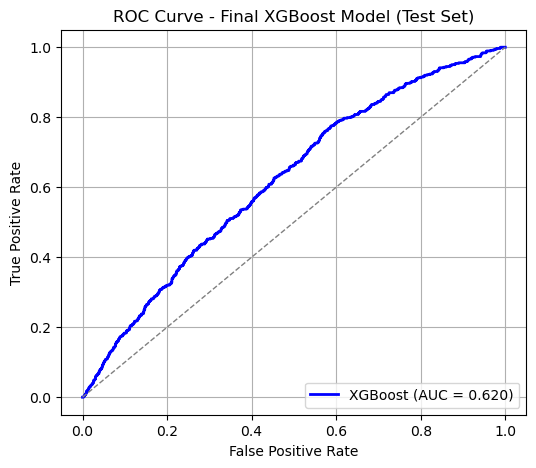


Final model saved successfully as '../models/final_model.pkl'


In [68]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import joblib

# Refit the final chosen model on full resampled training data
xgb.fit(x_train_res, y_train_res)

# Evaluate on test set
y_test_pred = xgb.predict(x_test)
y_test_prob = xgb.predict_proba(x_test)[:, 1]

print("\nFinal XGBoost Evaluation on Test Set:")
print(f"Accuracy  : {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision : {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall    : {recall_score(y_test, y_test_pred):.4f}")
print(f"F1-Score  : {f1_score(y_test, y_test_pred):.4f}")
print(f"ROC-AUC   : {roc_auc_score(y_test, y_test_prob):.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'XGBoost (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Final XGBoost Model (Test Set)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Save final model for Streamlit
joblib.dump(xgb, "../models/final_model.pkl")
print("\nFinal model saved successfully as '../models/final_model.pkl'")

### Now,
- Test Set Evaluation for TOP_10_FEATURES + ROC Curve + Save the Model for TOP_10_FEATURES


Final XGBoost Evaluation on Test Set:
Accuracy  : 0.8973
Precision : 0.1220
Recall    : 0.0979
F1-Score  : 0.1086
ROC-AUC   : 0.6210


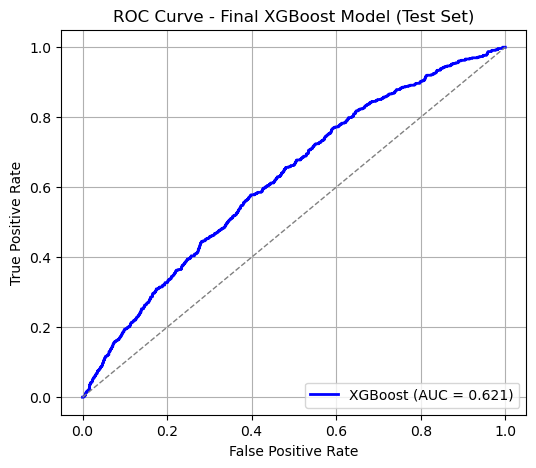


Final model saved successfully as '../models/final_model_10f.pkl'


In [69]:
# for top_10_features
# Refit the final chosen model on full resampled training data
xgb.fit(x_train_res[top_10_features], y_train_res)

# Evaluate on test set
y_test_pred = xgb.predict(x_test[top_10_features])
y_test_prob = xgb.predict_proba(x_test[top_10_features])[:, 1]

print("\nFinal XGBoost Evaluation on Test Set:")
print(f"Accuracy  : {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision : {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall    : {recall_score(y_test, y_test_pred):.4f}")
print(f"F1-Score  : {f1_score(y_test, y_test_pred):.4f}")
print(f"ROC-AUC   : {roc_auc_score(y_test, y_test_prob):.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'XGBoost (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Final XGBoost Model (Test Set)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Save final model for Streamlit
joblib.dump(xgb, "../models/final_model_10f.pkl")
print("\nFinal model saved successfully as '../models/final_model_10f.pkl'")

### Key Takeaways

- Behavioral insight: Claim likelihood increases for younger drivers and newer customers with short policy tenure.

- Vehicle risk: Older, high-power vehicles in densely populated zones are at greater claim risk.

- Geographical impact: Area cluster and population density significantly influence accident exposure.

- Model interpretability: Feature importance aligns with domain intuition, validating the model’s business relevance.